<h1>Human Variant Calling with Medaka</h1>

The tutorial is intended as an introduction to single nucleotide polymorphism (SNP) calling with `medaka` for targeted sequencing. For calling variants with whole genome sequencing please refer to the medaka [documentation](https://nanoporetech.github.io/medaka/snp.html#performing-variant-calling).

Computational requirements for this tutorial include:

* Computer running the **EPI2ME Labs** notebook Server
* At least 16Gb RAM

> ⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.



## Introduction

Medaka was designed to call small variants (substition, deletion, and insertion events), in whole genome sequencing. This tutorial aims to demonstate how to use Medaka to call substitution variants in human targeted sequencing. For completeness we will also attempt to call insertion and deletion (indel) variants, although as we we learn this stretches the methodolgy employeed by medaka when used with targeted, and particularly amplicon, data.

The goals from this tutorial include:

* Understand how medaka approaches small variant calling and how to apply it to targeted sequencing.
* Learn how to run medaka to call SNPs in Oxford Nanopore Technologies' sequencing data.
* Understand and be able to manipulate the output of Medaka's variant calling process.

The tutorial is supplied with a sample dataset containing reads spanning multiple targets from a human cell line.

## Getting started

The workflow below requires a single folder containing `.fastq` files from an Oxford Nanopore Technologies' sequencing device, or a single such file. Compressed or uncompressed files may be used. In addition 
a reference sequence `.fasta` file and a `.bed` file describing target regions within the reference sequence are required.

Before anything else we will create and set a working directory:

In [3]:
from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'snp_tutorial')

# create a work directory and move into it
tutorial_name = "human_amp_snp_calling"
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/human_amp_snp_calling


### Sample Data

To demonstrate the workflow below a sample dataset is included with this tutorial. The dataset comprises a manageable dataset spanning various targets from an experiment using the Oxford Nanopore Technologies' target sequencing protocol. We will download also a `.bed` file, this file describes the location of the gene in a tabular text document.

To download the sample files we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

# download the data
!wget "$site/$tutorial_name/sample_cas9.tar.gz"
# the data is in a compressed archive so let's decompress it
!tar -xzvf sample_cas9.tar.gz
!wget "$site/$tutorial_name/targets.bed"

To view the outcome of the download we can use the `tree` command to show the contents of the working directory:

In [4]:
!tree .

.
├── sample_cas9
│   └── fastq_pass
│       ├── FAK76554_9b52beb8b4f9ec458eb28c28b35822acaff84952_0.fastq
│       └── FAK76554_9b52beb8b4f9ec458eb28c28b35822acaff84952_1.fastq
├── sample_cas9.tar.gz
└── targets.bed

2 directories, 4 files


The files should also appear in the File Browser to the left-hand side of the screen.

For our analysis we will also need the human genome reference:

In [ ]:
!wget "$site"/grch38.tar.gz
!tar -xzvf grch38.tar.gz
# parts of the workflow don't accept compressed reference
!cd grch38 && gunzip grch38.fasta.gz

The reference contained within the above download is that which can also be obtained [here](http://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/seqs_for_alignment_pipelines.ucsc_ids/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz), the reasons for using this file are presented in Heng Li's [blog post](https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use).

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `input_file` variable below. To find the correct full path of a file you can navigate to it in the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

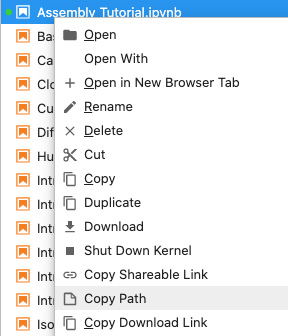

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.

### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook in the form below:

In [5]:
import os
import aplanat
import aplanat.graphics
import pandas as pd

from epi2melabs.notebook import InputForm, InputSpec

input_data = None
bed_file = None
output_folder = None
reference_genome = None
input_file = None
region_bed = None
exec_summary = None

def process_form(inputs):
    global input_data
    global bed_file
    global output_folder
    global reference_genome
    global region_bed
    global exec_summary
    global input_file
    
    input_data = inputs.input_data
    bed_file = inputs.bed_file
    output_folder = inputs.output_folder
    reference_genome = inputs.reference_genome

    input_file = os.path.join(output_folder, "input.fastq")

    # run a command to concatenate all the files together
    !echo "Making output folder"
    !mkdir -p "$output_folder"
    !test -f "$reference_genome" || "WARNING: Reference file does not exist"
    !rationalize_fastq -i "$input_data" -o "$input_file"

    region_bed = pd.read_csv(
        bed_file, sep='\t', header=None,
        # https://genome.ucsc.edu/FAQ/FAQformat.html#format1
        names=[
            'chrom', 'start', 'end',  #required
            'tname', 'score', 'strand', 'thickStart', 'thickEnd',
            'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])

    region_bed['region'] = [
        '{}:{}-{}'.format(x['chrom'], x.start, x.end)
        for _, x in region_bed.iterrows()]

    exec_summary = aplanat.graphics.InfoGraphItems()

desc = "Enter the paths to you input files and output folder here. The input data may be either a a single fastq, compressed or otherwise, file or a directory containing multiple such files"
input_form = InputForm(
    InputSpec('input_data', 'Input .fastq', 'sample_cas9', long_desc=desc),
    InputSpec('bed_file', 'Target .bed file', 'targets.bed'),
    InputSpec('output_folder', 'Output folder', 'analysis'),
    InputSpec('reference_genome', 'Reference .fasta', 'grch38/grch38.fasta'))
input_form.add_process_button(process_form)
input_form.display()

### Alignment of reads

Our first task in analysing our data is to align the sequence reads to the reference sequence. We do this with the `mini_align` program from the [`pomoxis`](https://github.com/nanoporetech/pomoxis) package. This is preinstalled in the **EPI2ME Labs** notebook server. Note that this command may take a while to run depending on the number of reads in your datasets. With the sample data (8000 reads) and using 4 compute threads (`-t 4` in the code), the alignments will take around 5 minutes.


In [ ]:
!run mini_align \
    -r "$reference_genome" -i "$input_file" \
    -p "$output_folder/alignments" \
    -t 4

While we are here we will calculate also a table summarising the alignment data, again using a program from `pomoxis`:

In [6]:
!stats_from_bam "$output_folder/alignments.bam" \
    > "$output_folder/alignments.stats"

aln_summary = pd.read_csv(
    '{}/alignments.stats'.format(output_folder),
    delimiter='\t')
exec_summary.append(
    'Read accuracy', aln_summary['acc'].median(), 'bullseye', '%')
exec_summary.append(
    'Throughput', aln_summary['read_length'].sum(), 'angle-up', 'B')

Mapped/Unmapped/Short/Masked: 7827/0/0/0


The summary file gives useful information on the alignment of each read to the reference sequence, including: chromosome, start and end coordinates, and the accuracy of the read with respect to the reference. We can plot a histogram of the latter quantity:

In [7]:
# Read summary graphs code (click play)

#load python libraries
import numpy as np
from bokeh.layouts import gridplot
import aplanat
from aplanat import annot, lines, util

x_grid, pdf = util.kernel_density_estimate(aln_summary['acc'])
mode = x_grid[np.argmax(pdf)]

p = lines.line(
    [x_grid], [pdf],
    x_axis_label="Read accuracy", y_axis_label="Read density")
p = annot.marker_vline(p, mode, label='mode: {:.1f}'.format(mode))
aplanat.show(p)

The alignment summary can be used also to count reads overlapping the target regions in the input `.bed` file. To do this we will use the `pyranges` python package. This analysis provides a quick QC step before proceeding to SNP calling.

In [8]:
# Tabulating read overlaps to targets (click play)
import pyranges as pr

targets = region_bed[['chrom','start','end','tname']].rename(
    columns={'chrom':'Chromosome','start':'Start','end':'End'}
)
targets = pr.PyRanges(targets)

reads = aln_summary.rename(
    columns = {'ref':'Chromosome','rstart':'Start','rend':'End', 'direction':'Strand'}
)
reads = pr.PyRanges(reads)
ovl_summary = targets.count_overlaps(reads)
display(ovl_summary.df)
exec_summary.append(
    'Reads per target', ovl_summary.df['NumberOverlaps'].median(), 'calculator')

,Chromosome,Start,End,tname,NumberOverlaps
0,chr1,155180400,155200000,MUC1,28
1,chr4,3072000,3078000,HTT,84
2,chr6,170556800,170566300,SCA17,76
3,chr9,27571600,27577500,C9orf72,39
4,chr11,2158100,2167500,INS,55
5,chr12,111596700,111603400,SCA2,231
6,chr14,92067100,92075400,SCA3,95
7,chr19,13204400,13211100,SCA6,62
8,chr22,45791500,45799400,SCA10,124
9,chrX,147910700,147933700,FMR1,70


## SNP Calling

Medaka calculates variants from read alignments stored within a `.bam` file. The workflow internal to Medaka was designed with whole genome sequencing in mind, it can however be coerced into being a tool for calling effectively SNP variants from targeted and amplicon datasets.

### Medaka's workflow

The workflow used within Medaka to call variants in human whole genome sequencing is outlined in the [documentation](https://nanoporetech.github.io/medaka/snp.html). Variant calling is a three step process:

1. call homozygous and heterozygous SNPs,
2. use the information contained within the heterozygous SNPs to haplotype the reads,
3. create haplotype consensus sequences for the two haplotypes and recombine the data into a single set of SNP and INDEL variants.

Examining the workflow we identify a possible problem for the calling of generic variants: the second and third steps steps rely on finding a sufficient number of heterozygous SNPs within each target region. For whole genome sequencing with long reads this is not an issue. For short targets or amplicons containing few or no heterozygous SNPs the reads cannot be partitioned into their corresponding haplotypes. For reference the average distance between heterozygous variants is ~630 bases in the GIAB HG002 sample:

In [9]:
# Calculating inter-HET variant distance (click play)

truth = (
   'https://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/'
   'HG002_NA24385_son/NISTv3.3.2/GRCh38/HG002_GRCh38_GIAB_highconf_CG-'
   'Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz')

!wget -O HG002_truth.vcf.gz "$truth"

def parse_vcf(fname):
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(fname, delimiter='\t', comment='#', names=header)
    return vcf

vcf = parse_vcf("HG002_truth.vcf.gz")
ishom = vcf['GT'].str.contains('HOMVAR')
vcf['het'] = ~ishom
hets = vcf.loc[vcf['het']][['POS', 'het']]
d = np.diff(hets['POS'].to_numpy())
d[d < 0] = 0
d[d > 10000] = 0
mean_dist = np.mean(d)  # crossed chr

import aplanat
from aplanat import hist, annot
p = hist.histogram(
    [d], [[1.0]*len(d)], bins=100, normalize=True,
    x_axis_label='Distance between HETs', y_axis_label='Density',
    xlim=(0, 4000), title='HG002 Inter-variant distance')
p = annot.marker_vline(p, mean_dist, label='mean: {:.0f}'.format(mean_dist))
aplanat.show(p)



--2020-10-19 16:29:22--  https://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG002_NA24385_son/NISTv3.3.2/GRCh38/HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.10, 2607:f220:41e:250::12, 2607:f220:41e:250::13, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129195923 (123M) [application/x-gzip]
Saving to: ‘HG002_truth.vcf.gz’

HG002_truth.vcf.gz  100%[===================>] 123.21M  30.4MB/s    in 9.1s    

2020-10-19 16:29:32 (13.6 MB/s) - ‘HG002_truth.vcf.gz’ saved [129195923/129195923]



#### Coverage requirements

As an additional consideration since Medaka is designed to work with whole genome sequencing datasets, the genome coverage is expected to be rather low compared to what might be obtained in a targeted sequencing experiment. Medaka's variant calling is optimised to work with reference coverage in the range of 30-100 fold. If a dataset contains more data than this it is recommended to first downsample the data to 80X.

Various tools can downsample a dataset, `pomoxis` includes a tool for doing just this whilst attempting to normalise coverage:



In [ ]:
!run subsample_bam

usage: subsample_bam [-h] [-o OUTPUT_PREFIX] [-r REGIONS [REGIONS ...]]
                     [-p PROFILE] [-O {fwd,rev}] [-t THREADS] [-q QUALITY]
                     [-a ACCURACY] [-c COVERAGE] [-l LENGTH]
                     [--any_fail | --all_fail] [-x PATIENCE] [-s STRIDE] [-P]
                     [-S SEED]
                     bam depth [depth ...]
subsample_bam: error: the following arguments are required: bam, depth


A more simple approach would be to use simply `samtools view` with its `-s` option.

### Calling variants

With the above considerations in mind we will now use Medaka to call variants.

Medaka contains a single program to perform all the necessary steps to produce a Variant Call Format (`.vcf`) file from a `.bam` file. To calculate variants efficiently we will give explicitely the regions of interest to medaka:

In [ ]:
# Running medaka to call variants (click play)

#medaka doesn't accept a bed file as input, but does accept a single region
with open(bed_file) as bed:
    for line in bed.readlines():
        chrom, start, stop, _ = line.split('\t')
        reg = '{}:{}-{}'.format(chrom, start, stop)
        print("Running medaka for {}".format(reg))
        !rm -rf "$output_folder/medaka_$reg"
        !run medaka_variant \
            -i "$output_folder/alignments.bam" -f grch38/grch38.fasta \
            -r "$reg" -t 4 -o "$output_folder/medaka_$reg"

The above code will have created a separate output folder for each entry in the input `.bed` file. Each folder will contain something like:

In [10]:
# sample output of medaka_variant per region
with open(bed_file) as bed:
    line = bed.readline()
    chrom, start, stop, _ = line.split('\t')
    reg = '{}:{}-{}'.format(chrom, start, stop)
    !tree "$output_folder/medaka_$reg"

analysis/medaka_chr1:155180400-155200000
├── alignments.bam
├── alignments.bam.bai
├── round_0_hap_mixed_phased.bam
├── round_0_hap_mixed_phased.bam.bai
├── round_0_hap_mixed_phased.vcf
├── round_0_hap_mixed_phased.vcf.gz
├── round_0_hap_mixed_phased.vcf.gz.tbi
├── round_0_hap_mixed_probs.hdf
├── round_0_hap_mixed_unphased.vcf
├── round_1_hap_1_probs.hdf
├── round_1_hap_1.vcf
├── round_1_hap_2_probs.hdf
├── round_1_hap_2.vcf
├── round_1_unfiltered.vcf
└── round_1.vcf

0 directories, 15 files


Many of these files are intermediate files that are not useful to most users (they can be automatically remove by using the `-d` option to `medaka_variant`). The most interesting outputs are:

* `round_0_hap_mixed_unphased.vcf` - a VCF containing the initial (unphased) SNP calls (not INDEL calls). The output of Step 1. in the workflow described above.
* `round_1_unfiltered.vcf` - a VCF containing the both SNP and INDEL calls derived from the independent haplotype consensus steps. The output of Step 3. in the workflow.
* `round_1.vcf` - a final output VCF calculated from `round_1_unfiltered.vcf` by applying a standard set of filters.

For longer target regions and amplicons the `round_1.vcf` file will be populated. For smaller regions, or regions of low heterozygosity, the haplotype partitioning step may have failed and only `round_0_hap_mixed_unphased.vcf` will contain useful data.

### Annotating the variant calls

The step above calculated independently a `.vcf` file for all regions of interest. In this step we will aggregate and annotate these files.

A usual step in analysing putative variants is to consider each variant in terms of the number of reads with support for the alternative and reference alleles. To enable this analysis Medaka has a dedicated tool which performs realignment of reads to determine which allele the read best supports.

> ***The outcome of this analysis may prove counter-intuitive. The neural network used within Medaka can be considered as encoding knowledge (prior beliefs) on the expected base distributions for alternative sequences. In the presence of errorful reads the neural network provides additional power over naively counting bases. Users are advised not to trivially dismiss calls based on incongruent read counts.***

To aggregate the independent `.vcf` files run the code cell below:

In [11]:
# Aggregate and annotate variant calls (click play)
files = list()
concat_vcf = os.path.join(output_folder, "combined.vcf")
annot_vcf = os.path.join(output_folder, "combined_annot.vcf")
with open(bed_file) as bed:
    for line in bed.readlines():
        chrom, start, stop, _ = line.split('\t')
        reg = '{}:{}-{}'.format(chrom, start, stop)
        path = os.path.join(output_folder, "medaka_{}".format(reg))
        for fname in ('round_1.vcf', 'round_0_hap_mixed_unphased.vcf'):
            fname = os.path.join(path, fname)
            if os.path.isfile(fname):
                files.append(fname)
                break
all_files = ' '.join(files)
print(" - Concatenating VCFs")
!bcftools concat $all_files > $concat_vcf
print(" - Annotating VCFs")
!run medaka tools annotate $concat_vcf grch38/grch38.fasta \
    "$output_folder/alignments.bam" $annot_vcf

 - Concatenating VCFs
Checking the headers and starting positions of 10 files
Concatenating analysis/medaka_chr1:155180400-155200000/round_1.vcf	0.005149 seconds
Concatenating analysis/medaka_chr4:3072000-3078000/round_1.vcf	0.000375 seconds
Concatenating analysis/medaka_chr6:170556800-170566300/round_1.vcf	0.000551 seconds
Concatenating analysis/medaka_chr9:27571600-27577500/round_1.vcf	0.000488 seconds
Concatenating analysis/medaka_chr11:2158100-2167500/round_1.vcf	0.000492 seconds
Concatenating analysis/medaka_chr12:111596700-111603400/round_1.vcf	0.000463 seconds
Concatenating analysis/medaka_chr14:92067100-92075400/round_1.vcf	0.000441 seconds
Concatenating analysis/medaka_chr19:13204400-13211100/round_1.vcf	0.000461 seconds
Concatenating analysis/medaka_chr22:45791500-45799400/round_1.vcf	0.000458 seconds
Concatenating analysis/medaka_chrX:147910700-147933700/round_1.vcf	0.000379 seconds
 - Annotating VCFs


### Examining the annotations

Having created our combined and annotated `.vcf` we will now highlight a few of its features in order to provide pointers for further filtering and analysis.

VCF files generically comprise a header section, a set of mandatory fields together with an `INFO` field which may contain addition useful information. In common with many other tools Medaka uses the `INFO` field to embed an additional data table. The annotation program above added the following to the `INFO` field (which can be found in the `.vcf` header information):

* ***DP*** - Depth of reads at pos
* ***DPS*** - Depth of reads at pos by strand (fwd, rev)
* ***DPSP*** - Depth of reads spanning pos +-25
* ***SR*** - Depth of spanning reads by strand which best align to each allele (ref fwd, ref rev, alt1 fwd, alt1 rev, etc.)
* ***AR*** - Depth of ambiguous spanning reads by strand which align equally well to all alleles (fwd, rev)
* ***SC*** - Total alignment score to each allele of spanning reads by strand (ref fwd, ref rev, alt1 fwd, alt1 rev, etc.)

There are a variety of VCF parsers available in Python, but since the file is essentially a tab-separated table here we use simply the `pandas` library to extract the `INFO` fields above into their own columns and then count variants according to the depth `DP` column and Medaka's in built filtering:


In [12]:
# Parsing VCF information to produce QC information (click play)
def parse_vcf(fname):
    # read a vcf and move "columns" from the INFO field into the table
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(fname, delimiter='\t', comment='#', names=header) 
    extra = vcf['INFO'].str.split(";") \
        .apply(lambda x: dict([y.split("=") for y in x])) \
        .tolist()
    return vcf.join(pd.DataFrame(extra))

depth_filter = 20

vcf = parse_vcf(annot_vcf)
# summarise variants by quality and sequencing depth
vcf['lowdepth'] = vcf['DP'].astype(int) < depth_filter
counts = vcf.groupby(["FILTER", "lowdepth"]).size() \
    .reset_index().rename(columns={"FILTER":'lowqual', 0: 'count'})
counts['lowqual'] = counts['lowqual'].apply(lambda x: x == 'lowqual')
display(counts)
good_variants = counts.loc[
    (counts['lowqual'] == False) & (counts['lowdepth'] == False), 'count'] \
    .tolist()[0]
exec_summary.append('Pass Variants', good_variants, 'adjust')

,lowqual,lowdepth,count
0,False,False,64
1,False,True,313
2,True,False,19
3,True,True,268


This gives just a flavour of the information available in the `INFO` field. For more advanced filtering of variants users are encouraged to read the `bcftools query` [documentation](https://samtools.github.io/bcftools/howtos/filtering.html) and examples. For example to perform a similar manipulation as the above python snippet, only outputting variants with high quality and depth to a tab-separated text file:

In [13]:
!bcftools query -i "FILTER='PASS' && DP>20" -f '%CHROM\t%POS\t%REF\t%ALT\t[ %GT]\n' $annot_vcf > my_filtered.variants.vcf

## Headline numbers

As a final summary of the experiment the infographic below displays a small set of headline numbers captured through the course of the analysis:

In [14]:
# Executive summary (click play)
pinger.send_notebook_ping('stop', 'snp_tutorial')
aplanat.show(aplanat.graphics.infographic(exec_summary.values(), ncols=2))

## Summary

This tutorial has stepped through use of Medaka's variant calling functionality as applied to targeted sequencing experiments. We have discussed how Medaka performs variant calling and how that may have and effect on the results. Through the aid of an example dataset we have highlighted how to interpret the key outputs of the workflow.

The analysis presented can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within the **EPI2ME Labs** notebook server environment.
